# GLM tutorial

Here, we will implement a simple binomial GLM using data for California standardized testing results (STAR testing, for those of you who grew up here) for grades 2-11. This dataset consists of results for 303 unified school districts, and the binary response variable represents the number of 9th graders scoring above the national median for the math section.

In [2]:
# import packages for tutorial 
import statsmodels.api as sm
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import optimize

### Load the dataset from the `statsmodels` package

More information about `statsmodels` datasets can be found [here](https://www.statsmodels.org/devel/datasets/index.html).

In [3]:
print(sm.datasets.star98.NOTE)

::

    Number of Observations - 303 (counties in California).

    Number of Variables - 13 and 8 interaction terms.

    Definition of variables names::

        NABOVE   - Total number of students above the national median for the
                   math section.
        NBELOW   - Total number of students below the national median for the
                   math section.
        LOWINC   - Percentage of low income students
        PERASIAN - Percentage of Asian student
        PERBLACK - Percentage of black students
        PERHISP  - Percentage of Hispanic students
        PERMINTE - Percentage of minority teachers
        AVYRSEXP - Sum of teachers' years in educational service divided by the
                number of teachers.
        AVSALK   - Total salary budget including benefits divided by the number
                   of full-time teachers (in thousands)
        PERSPENK - Per-pupil spending (in thousands)
        PTRATIO  - Pupil-teacher ratio.
        PCTAF    - Percenta

Let's break it down:

- `NABOVE` and `NBELOW` represent the binary response variable
- `LOWINC` through `PCTYRRND` represent the **12** independent variables, or regressors. These would be represented by $\mathbf X_1,...,\mathbf X_n$ for $n$ regressors.
- There are **8** interaction terms, representing non-linear interactions between two or more regressors. When an interaction is present, the effect of a regressor on the response variable depends on the value(s) of the variable(s) which it interacts with. The values of these interaction variables is simply the product of its interacting terms; for example, if variables $A$ and $B$ are interacting, the value of its interaction term, $\mathbf X_{AB} = \mathbf X_A \circ \mathbf X_B$.

Now let's preview the dataset as a `pandas` dataframe (via `statsmodels` functions).

In [4]:
data = sm.datasets.star98.load_pandas()
data.data.head()

,NABOVE,NBELOW,LOWINC,PERASIAN,PERBLACK,PERHISP,PERMINTE,AVYRSEXP,AVSALK,PERSPENK,...,PCTCHRT,PCTYRRND,PERMINTE_AVYRSEXP,PERMINTE_AVSAL,AVYRSEXP_AVSAL,PERSPEN_PTRATIO,PERSPEN_PCTAF,PTRATIO_PCTAF,PERMINTE_AVYRSEXP_AVSAL,PERSPEN_PTRATIO_PCTAF
0,452.0,355.0,34.39730,23.299300,14.235280,11.411120,15.91837,14.70646,59.15732,4.445207,...,0.0,22.222220,234.102872,941.68811,869.9948,96.50656,253.52242,1238.1955,13848.8985,5504.0352
1,144.0,40.0,17.36507,29.328380,8.234897,9.314884,13.63636,16.08324,59.50397,5.267598,...,0.0,0.000000,219.316851,811.41756,957.0166,107.68435,340.40609,1321.0664,13050.2233,6958.8468
2,337.0,234.0,32.64324,9.226386,42.406310,13.543720,28.83436,14.59559,60.56992,5.482922,...,0.0,0.000000,420.854496,1746.49488,884.0537,103.92435,295.75929,1022.4252,25491.1232,5605.8777
3,395.0,178.0,11.90953,13.883090,3.796973,11.443110,11.11111,14.38939,58.33411,4.165093,...,0.0,7.142857,159.882095,648.15671,839.3923,90.11341,204.34375,1061.4545,9326.5797,4421.0568
4,8.0,57.0,36.88889,12.187500,76.875000,7.604167,43.58974,13.90568,63.15364,4.324902,...,0.0,0.000000,606.144976,2752.85075,878.1943,81.22097,226.54248,983.7059,38280.2616,4254.4314


In statsmodels, `endog` refers to the response variable(s). Here, it will return `NABOVE` and `NBELOW`.

In [5]:
data.endog.head()

,NABOVE,NBELOW
0,452.0,355.0
1,144.0,40.0
2,337.0,234.0
3,395.0,178.0
4,8.0,57.0


`exog` refers to all of the other independent variables/regressors/interactions.

In [6]:
data.exog.head()

,LOWINC,PERASIAN,PERBLACK,PERHISP,PERMINTE,AVYRSEXP,AVSALK,PERSPENK,PTRATIO,PCTAF,PCTCHRT,PCTYRRND,PERMINTE_AVYRSEXP,PERMINTE_AVSAL,AVYRSEXP_AVSAL,PERSPEN_PTRATIO,PERSPEN_PCTAF,PTRATIO_PCTAF,PERMINTE_AVYRSEXP_AVSAL,PERSPEN_PTRATIO_PCTAF
0,34.39730,23.299300,14.235280,11.411120,15.91837,14.70646,59.15732,4.445207,21.71025,57.03276,0.0,22.222220,234.102872,941.68811,869.9948,96.50656,253.52242,1238.1955,13848.8985,5504.0352
1,17.36507,29.328380,8.234897,9.314884,13.63636,16.08324,59.50397,5.267598,20.44278,64.62264,0.0,0.000000,219.316851,811.41756,957.0166,107.68435,340.40609,1321.0664,13050.2233,6958.8468
2,32.64324,9.226386,42.406310,13.543720,28.83436,14.59559,60.56992,5.482922,18.95419,53.94191,0.0,0.000000,420.854496,1746.49488,884.0537,103.92435,295.75929,1022.4252,25491.1232,5605.8777
3,11.90953,13.883090,3.796973,11.443110,11.11111,14.38939,58.33411,4.165093,21.63539,49.06103,0.0,7.142857,159.882095,648.15671,839.3923,90.11341,204.34375,1061.4545,9326.5797,4421.0568
4,36.88889,12.187500,76.875000,7.604167,43.58974,13.90568,63.15364,4.324902,18.77984,52.38095,0.0,0.000000,606.144976,2752.85075,878.1943,81.22097,226.54248,983.7059,38280.2616,4254.4314


### Visualize
Let's visualize the data and get a high-level idea of what's going on. To start, let's use seaborn to visualize the relationship between each of the independent variables, excluding the interaction terms, with the percentage of 9th grade students in each district scoring above the national median on the math section of the STAR test (100*`NABOVE`/(`NABOVE`+`NBELOW`)). 

It will be convenient to first reformat the data table into a form that is more friendly for exploratory data visualization. If you recall, each column represents a variable. We will reshape the table such that for each of the response variables (`id_vars`), there is one entry for each of the regressors (`value_vars`). By default, any columns not set as `id_vars` will be interpreted as `value_vars`. Each sample will have a record of the variable name and value. This process is called [**melting**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html) the dataframe.

Here, we will subset the data table to the columns containing the binary response variables (`NABOVE` and `NBELOW`) and the first 12 variables (excluding the interaction terms). This corresponds to the first 14 columns of the dataframe. 

In [7]:
plot_df = data.data.iloc[:,:14].melt(id_vars = ['NABOVE','NBELOW'])
plot_df.head()

,NABOVE,NBELOW,variable,value
0,452.0,355.0,LOWINC,34.39730
1,144.0,40.0,LOWINC,17.36507
2,337.0,234.0,LOWINC,32.64324
3,395.0,178.0,LOWINC,11.90953
4,8.0,57.0,LOWINC,36.88889


Next, we add columns corresponding to the percentage of students above the national median (`PCTABOVE`) and the percentage of students below the national median (`PCTBELOW`).

Then we will use `seaborn` to generate [line plots](https://seaborn.pydata.org/generated/seaborn.regplot.html) relating `PCTABOVE` to each of the 12 independent variables selected. 

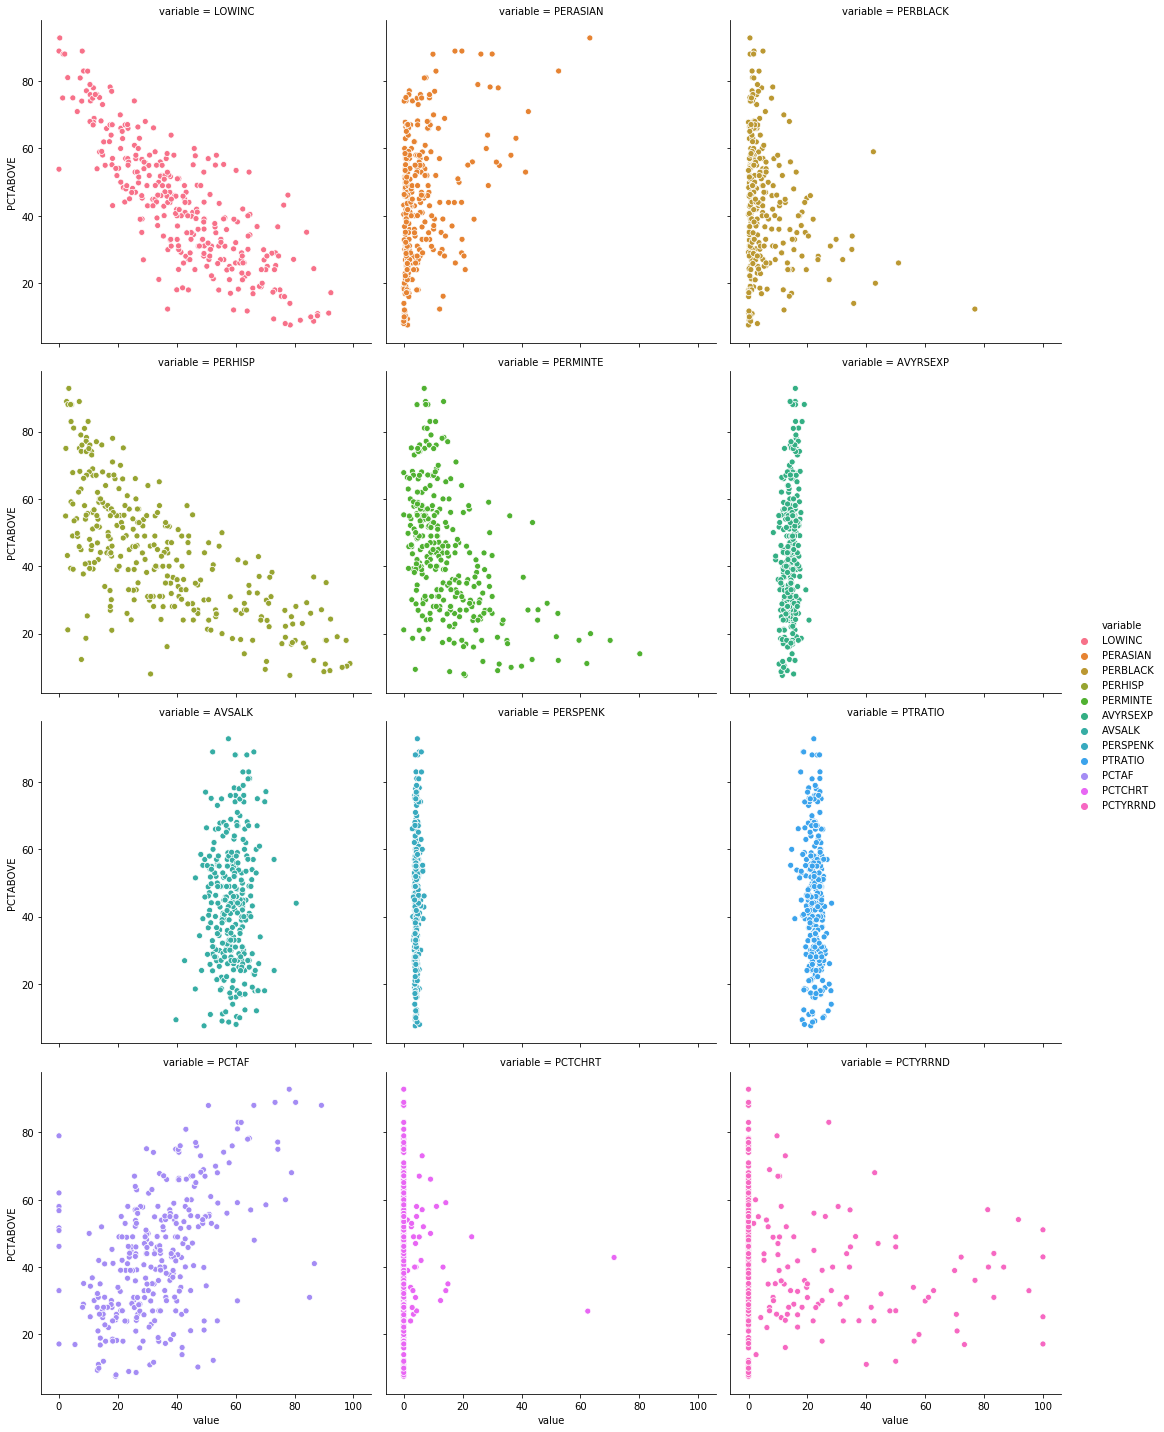

In [12]:
plot_df['PCTABOVE'] = 100*plot_df['NABOVE']/(plot_df['NABOVE']+plot_df['NBELOW'])
plot_df['PCTBELOW'] = 100*plot_df['NBELOW']/(plot_df['NABOVE']+plot_df['NBELOW'])

sns.relplot(x = 'value', y = 'PCTABOVE', hue = 'variable', kind='scatter',
             col = 'variable', col_wrap=3, aspect=1, data = plot_df)
plt.show()

Conversely, we can do the same thing, but with `PCTBELOW` on the y-axis this time.

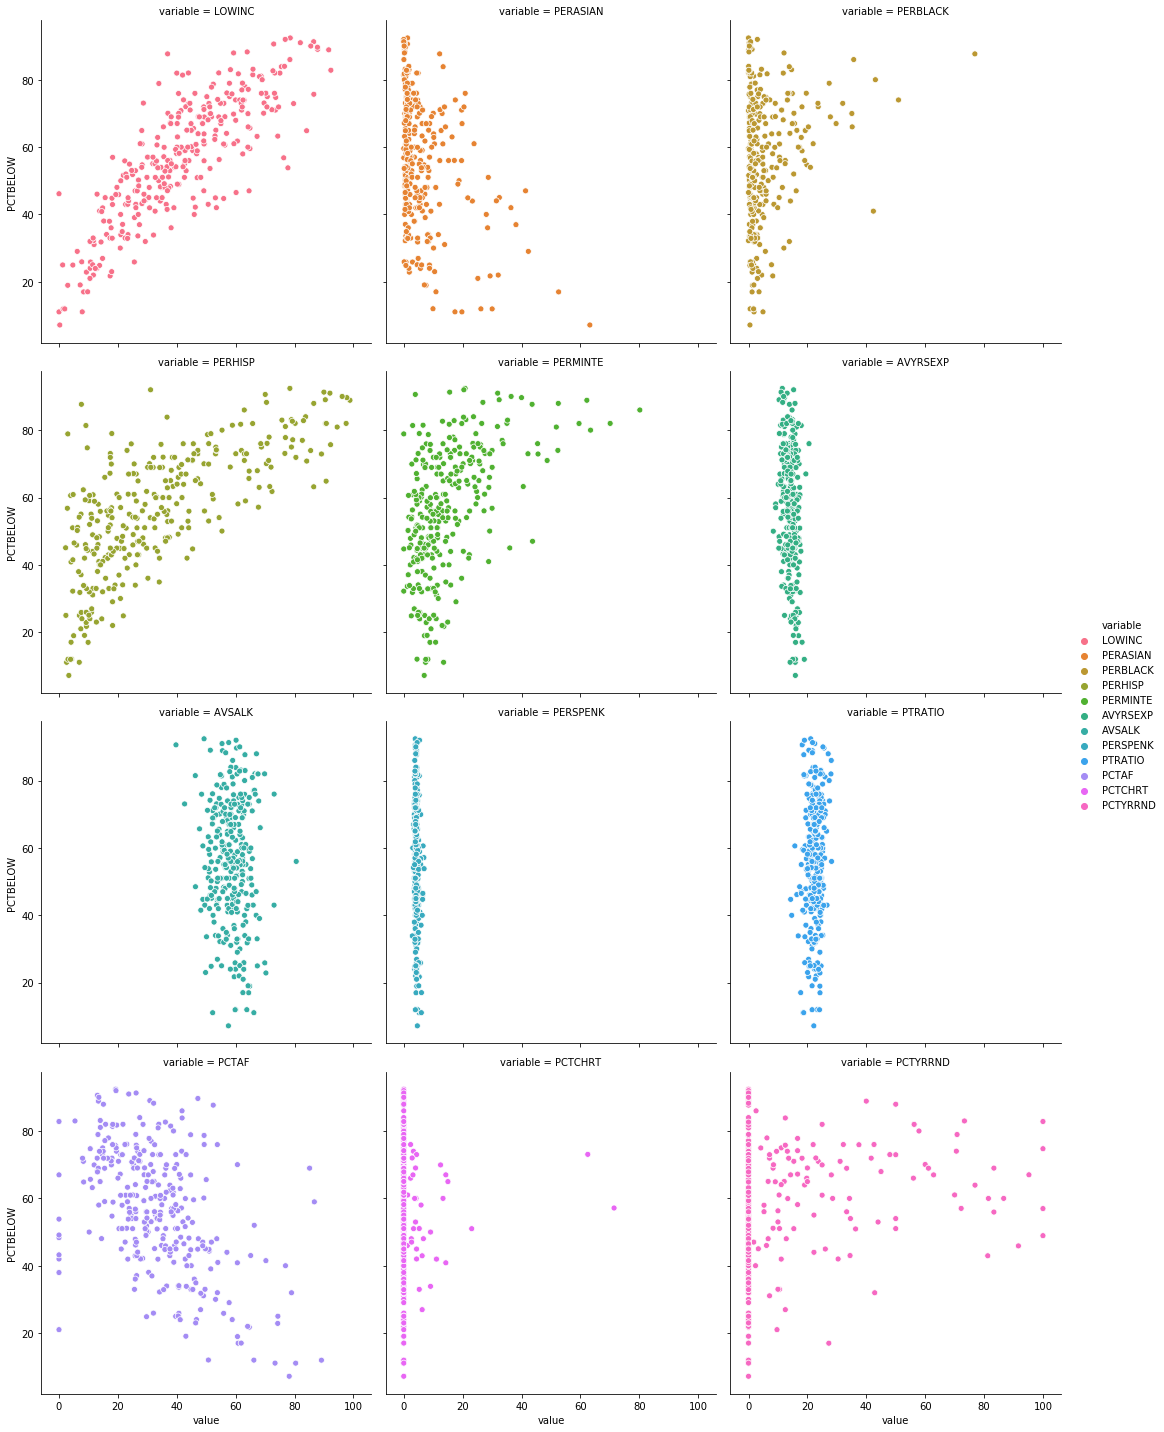

In [13]:
sns.relplot(x = 'value', y = 'PCTBELOW', hue = 'variable', kind='scatter',
             col = 'variable', col_wrap=3, aspect=1, data = plot_df)
plt.show()

Let's also visualize the distributions of the values of the independent variables (excluding interactions).

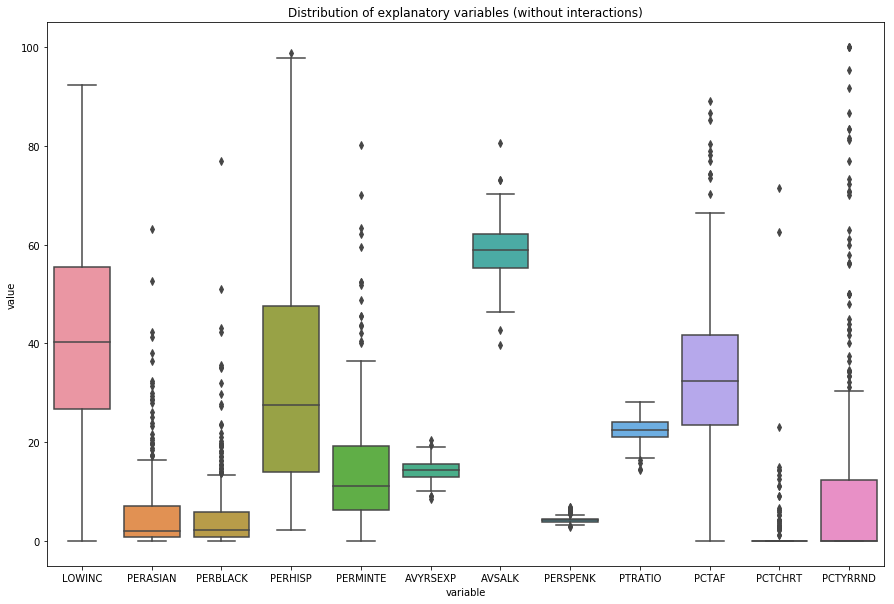

In [9]:
plt.figure(figsize = (15,10))
sns.boxplot(x='variable',y='value',data = data.exog.iloc[:,:12].melt())
plt.title('Distribution of explanatory variables (without interactions)')
plt.show()

### [The Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution)
The response variable is binomially distributed - this means you have a discrete, non-negative number of "successes" and a discrete, non-negative number of "failures". Here, this corresponds to `NABOVE` and `NBELOW`.

##### Parameterization
The binomial distribution is parameterized by $n\in \mathbb N$ and $p\in [0,1]$, and is expressed as $X\sim\text{Binomial}(n,p)$, where $X$ is a binomial random variable.

##### PMF
The probability mass function expresses the probability of getting $k$ successes in $n$ trials:
$$p(k,n,p)=\Pr(k;n,p)=\Pr(X=k)={n\choose k}p^k(1-p)^{n-k}$$
for $k=0,1,2,...,n,$ where ${n\choose k}$ is the binomial coefficient:
$${n\choose k}=\frac{n!}{k!(n-k)!}.$$

Essentially:
- $k$ successes occur with probability $p^k$, and
- $n-k$ failures occur with probability $(1-p)^{n-k}$

Becasue the $k$ successes can occur at any point within the $n$ trials, there are ${n\choose k}$ different ways of observing $k$ successes in $n$ trials.

### Link function for the Binomial distribution - [Binary Logistic Regression](https://newonlinecourses.science.psu.edu/stat504/node/216/)

The Binomial GLM can be expressed as:
$$y_i \sim \text{Binomial}(n_i,p_i)$$

with the logit link function:
$$p_i = \text{logit} ^{-1}(\mathbf X \beta) = \frac{\exp(\mathbf X \beta)}{1+\exp(\mathbf X \beta)} = \frac{1}{1+\exp(-\mathbf X \beta)}$$

### Implement the GLM
We need to estimate values of $\beta$ corresponding to each of the variables in $\mathbf X$, to give an estimate of the effect size of each predictor - that is, a measure of the effect that they have on the binomial response variable, which in this case is `NABOVE`.

For each sample (district) in the dataset, we have $k_i$ (`NABOVE`) and $n_i$ (`NABOVE`+`NBELOW`). We can estimate $p_i$ using the link function above, as we have the values of $\mathbf X$ from the dataset in `data.exog`. The values of $\beta$ giving the value of $p_i$ that defines a distribution shape that best fits to the data - comprised of $\mathbf X$ and $k_i =$`NABOVE` - are to be estimated by minimizing the log-likelihood function.

##### [Likelihood function](https://en.wikipedia.org/wiki/Likelihood_function)
We will minimize the negative log-likelihood. Here, we will use the scipy implementation of [`logpmf`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html) and the parameters $n,k,p$ to obtain the log-likelihood. The log-likelihood function can be defined as:

$$\log (\mathcal{L}(n,k,p\mid \mathbf{x}))=\sum_{i=1}^{N} \log (p(x_i\mid n,k,p)) = \sum_{i=1}^{N} \log (P(X=x_i\mid n,k,p)),$$

where,
- $n,k,p$ are the parameters defining the shape of the binomial distribution,
- $N$ represents the total number of school districts (303),
- $x_i$ represents `NABOVE` for district $i$

In [19]:
# define the negative log-likelihood function
def loglik(betas, x, y):
    '''betas = effect sizes of variables (parameters to estimate)
    x = values of variables
    y = NABOVE and NBELOW'''
    
    nTrials = y.NABOVE + y.NBELOW
    pSuccess = (1+np.exp(-np.dot(x,betas)))**-1
    ll = stats.binom.logpmf(k = y.NABOVE, 
                            n = nTrials,
                            p = pSuccess)
    return -ll.sum()

### Fit the model
For this example, we will restrict the number of variables to just the first 5 independent variables. This is because the optimizer can struggle with a large parameter space (a lot of $\beta$ values).

In [20]:
# fit model with first 5 variables interactions
res_five = optimize.minimize(fun = loglik,
                            x0 = np.zeros(5),
                            args = (data.exog.iloc[:,:5], data.endog),
                                      method = 'Nelder-Mead')

In [21]:
res_five

 final_simplex: (array([[-0.00694075,  0.034228  , -0.01203383, -0.00623375, -0.00491257],
       [-0.00694209,  0.03422786, -0.01202921, -0.0062293 , -0.00491935],
       [-0.00694485,  0.03422865, -0.01202725, -0.00622885, -0.00491606],
       [-0.00694175,  0.03422388, -0.01202843, -0.0062315 , -0.00491556],
       [-0.00694161,  0.03423066, -0.01202717, -0.00623275, -0.00491647],
       [-0.00694219,  0.03422552, -0.01202785, -0.00623148, -0.0049142 ]]), array([6787.56809261, 6787.56809815, 6787.56809911, 6787.56813934,
       6787.56814474, 6787.56815288]))
           fun: 6787.568092614503
       message: 'Optimization terminated successfully.'
          nfev: 471
           nit: 286
        status: 0
       success: True
             x: array([-0.00694075,  0.034228  , -0.01203383, -0.00623375, -0.00491257])

Let's prin tthe values of the coefficients for the first five independent variables in the model:

In [36]:
for x,y in zip(list(data.exog)[:5], res_five.x):
    print("coeff for %s = %.3g" % (x,y))

coeff for LOWINC = -0.00694
coeff for PERASIAN = 0.0342
coeff for PERBLACK = -0.012
coeff for PERHISP = -0.00623
coeff for PERMINTE = -0.00491


Let's visualize the values of those $\beta$ estimates:

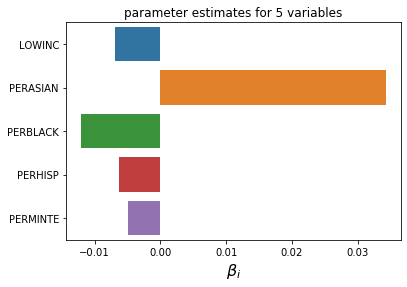

In [37]:
sns.barplot(x = res_five.x, y = list(data.exog)[:5])
plt.xlabel(r'$\beta_i$', fontsize=16)
plt.title('parameter estimates for 5 variables')
plt.show()

Let's see what happens if we fit the model with an additional variable - this time, we'll use the first 6 variables.

In [38]:
# fit model with first 6 variables 
res_six = optimize.minimize(fun = loglik,
                            x0 = np.zeros(6),
                            args = (data.exog.iloc[:,:6], data.endog),
                                      method= 'Nelder-Mead')

In [39]:
res_six

 final_simplex: (array([[-0.01590932,  0.01609357, -0.01787977, -0.01419682, -0.00036064,
         0.06145964],
       [-0.01591138,  0.01609379, -0.01787988, -0.0141972 , -0.00035909,
         0.06146251],
       [-0.01591153,  0.01609426, -0.01787249, -0.01419569, -0.00036293,
         0.06145954],
       [-0.01590968,  0.01609296, -0.01787834, -0.01419893, -0.00036116,
         0.06146444],
       [-0.01591061,  0.01609341, -0.01787214, -0.01419534, -0.00036661,
         0.06146092],
       [-0.01590938,  0.01609775, -0.01787701, -0.01419639, -0.00036181,
         0.06145334],
       [-0.0159083 ,  0.01609225, -0.01787861, -0.01419909, -0.00035882,
         0.06145731]]), array([3727.33715537, 3727.3371699 , 3727.33717456, 3727.33718084,
       3727.33719259, 3727.33720626, 3727.33722308]))
           fun: 3727.3371553689353
       message: 'Optimization terminated successfully.'
          nfev: 785
           nit: 508
        status: 0
       success: True
             x: array([-0

Print coefficients

In [40]:
for x,y in zip(list(data.exog)[:6], res_six.x):
    print("coeff for %s = %.3g" % (x,y))

coeff for LOWINC = -0.0159
coeff for PERASIAN = 0.0161
coeff for PERBLACK = -0.0179
coeff for PERHISP = -0.0142
coeff for PERMINTE = -0.000361
coeff for AVYRSEXP = 0.0615


Visualize:

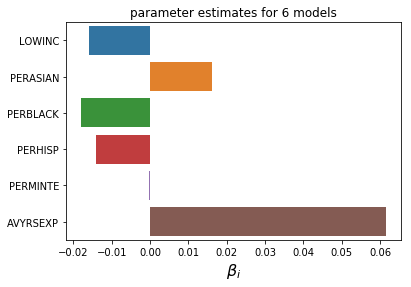

In [16]:
sns.barplot(x = res_six.x, y = list(data.exog)[:6])
plt.xlabel(r'$\beta_i$', fontsize=16)
plt.title('parameter estimates for 6 models')
plt.show()

### Does including another variable improve the model fit? 

We can use the [**likelihood-ratio test**](https://en.wikipedia.org/wiki/Likelihood-ratio_test) to determine whether the model with six variables fits the data better than the model with five variables. 

$H_0$: The model with six variables does not fit the data significantly better than the model with five variables.

$H_A$: The model with six variables fits the data significantly better than the model with five variables.

The likelihood ratio can be computed as:

$$ LR = -2\ln{\left( \frac{\mathcal L(\theta_0)}{\mathcal L(\theta_A)} \right)} = -2\left(\ln{\left(\mathcal L(\theta_0)\right)}-\ln{\left(\mathcal L(\theta_A)\right)}\right)$$

Because $LR$ is [$\chi^2$-distributed](https://en.wikipedia.org/wiki/Chi-squared_distribution), we can use this property to determine the p-value of the LRT:

$$ p = 1-\text{CDF}_k(LR), $$

where $k$ is the degrees of freedom, or the difference in the number of parameters for $H_0$ and $H_A$. In our example, $k = 6-5 = 1$. To compute the p-value, we will use the scipy implementation of the survival function, [`sf`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html). 

In [30]:
# likelihood-ratio test
def LRT(loglik_null, loglik_alt, nparams_null, nparams_alt):
    df = nparams_alt - nparams_null
    lr = -2*(loglik_null - loglik_alt)
    p = stats.chi2.sf(lr, df)
    return (lr, p)

Because we've defined the `LRT` function to take the log-likelihoods of $H_0$ and $H_A$, but our minimization functions computed the _negative_ log-likelihoods, we have to make sure to make this correction when passing those values to `LRT`.

In [31]:
lr, p = LRT(-res_five.fun, -res_six.fun, 5, 6)
print('LR = %.3g, p = %.3g' % (lr, p))

LR = 6.12e+03, p = 0


Let's discuss what this means!

### statsmodels GLM implementation

To see how we did, let's do exactly what we did above, but with the builtin [statsmodels implementation of GLMs](https://www.statsmodels.org/stable/glm.html). Let's compare the results for fitting 6 variables.

In [19]:
glm_binom = sm.GLM(data.endog, data.exog.iloc[:,:6], family=sm.families.Binomial())
res = glm_binom.fit()
print(res.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     ['NABOVE', 'NBELOW']   No. Observations:                  303
Model:                              GLM   Df Residuals:                      297
Model Family:                  Binomial   Df Model:                            5
Link Function:                    logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -3727.3
Date:                  Tue, 01 Oct 2019   Deviance:                       5536.2
Time:                          13:32:36   Pearson chi2:                 5.50e+03
No. Iterations:                       4   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
LOWINC        -0.0159      0.000    -43.482      0.000      -0.017      -0.015
PERASIAN       0.0161      0.001  

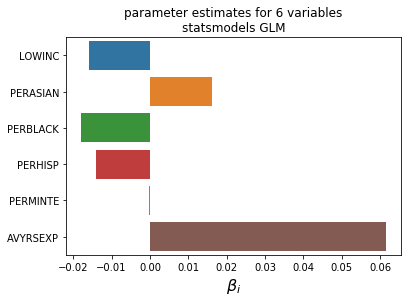

In [20]:
sns.barplot(x = res.params, y = list(data.exog)[:6])
plt.xlabel(r'$\beta_i$', fontsize=16)
plt.title('parameter estimates for 6 variables\nstatsmodels GLM')
plt.show()

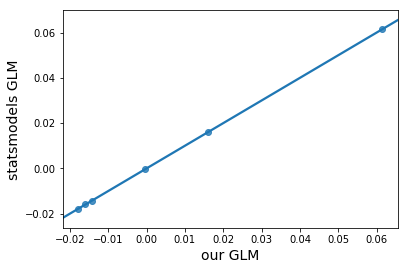

In [21]:
sns.regplot(x = res_six.x, y = res.params)
plt.xlabel('our GLM', fontsize = 14)
plt.ylabel('statsmodels GLM', fontsize = 14)
plt.show()

How do our estimates compare to these?

You could also fit a GLM to the full dataset:

In [22]:
glm_binom = sm.GLM(data.endog, data.exog, family=sm.families.Binomial())
res.full = glm_binom.fit()
print(res.full.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     ['NABOVE', 'NBELOW']   No. Observations:                  303
Model:                              GLM   Df Residuals:                      283
Model Family:                  Binomial   Df Model:                           19
Link Function:                    logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -3000.5
Date:                  Tue, 01 Oct 2019   Deviance:                       4082.4
Time:                          13:32:36   Pearson chi2:                 4.05e+03
No. Iterations:                       5   Covariance Type:             nonrobust
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
LOWINC                     -0.0169      0.000    -39.491      0.000      -0.018      -0

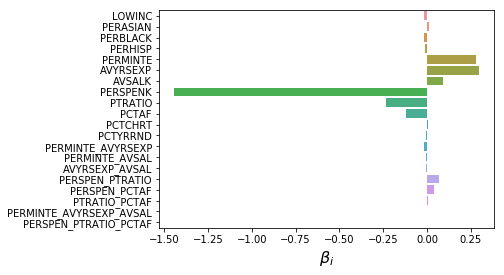

In [23]:
sns.barplot(x = res.full.params, y = list(data.exog))
plt.xlabel(r'$\beta_i$', fontsize=16)
plt.show()